# Using Subsample Particles with CompaSO Halos

## Background
In AbacusSummit, every particle falls into one of three sets:
- subsample A (3%)
- subsample B (7%)
- not a subsample particle

Membership in these sets is determined by a hash of the particle ID, and so is consistent across time (and even between simulations, roughly speaking).  Since the set of A and B particles is disjoint, the union of the two sets produces a 10% subsample.

When a CompaSO halo is found, any subsample A or B particles in that halo are appended to an array, which is output as a data product alongside the halo catalog.  A and B particles go into separate arrays, and these arrays are saved in separate files (with names like `halo_rv_A` or `halo_pid_B`). Each halo catalog entry (record) contains the indexing information needed to find its subsample particles in those arrays.  The `CompaSOHaloCatalog` interface uses that information to load the particles transparently when the user asks for them.

In particular, these outputs were designed with HOD applications in mind.  For example, the `AbacusHOD` module uses these subsample particles to help determine where to place HOD tracers.  Many HOD applications will only need the A subsample, so we'll focus on them in this notebook.

## What if I want all particles in a halo?
While a limited number of simulations have full timeslice outputs (i.e. 100% particle outputs), the data model is such that the assocation between halos and particles in the full timeslices is not saved.  New halo finding could be run on the full timeslices, but in general, only the A and B subsamples are available for a halo.

## Loading and Plotting the Subsamples
This notebook walks through loading subsample particles and doing some plotting and sanity checks to help users understand the data model.

We'll start with the basic imports:

In [1]:
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from abacusnbody.data.compaso_halo_catalog import CompaSOHaloCatalog

We'll next load the halo catalog. We'll use the mini simulation included in the test data, so this notebook can be run without downloading AbacusSummit data.  We'll use the `subsamples` parameter to indicate we want the A subsample particles.

In [2]:
catdir = Path('../../../tests/Mini_N64_L32/halos/z0.000')
cat = CompaSOHaloCatalog(catdir, subsamples=dict(A=True))
print(cat)

CompaSO Halo Catalog
Mini_N64_L32 @ z=0
------------------
     Halos:      381 halos,      91 fields, 0.000244 GB
Subsamples: 2.54e+03 particles,   2 fields, 6.09e-05 GB
Cleaned halos: True
Halo light cone: False


We see we have a small simulation with 381 halos and ~2540 subsample particles.

Is that about the right number of particles?  It should be about 3% of the total particles in halos (the fraction 0.03 is stored in the `ParticleSubsampleA` parameter):

In [3]:
cat.halos['N'].sum() * cat.header['ParticleSubsampleA']

2549.46

2549 matches well with our expectation.

Now let's look at the subsamples themselves:

In [4]:
cat.subsamples

pos,vel
float32[3],float32[3]
-14.187456 .. -5.318592,477.53906 .. 108.39844
-14.207712 .. -5.357984,228.51562 .. -190.42969
-14.151616 .. -5.303104,421.875 .. -117.1875
-14.161888 .. -5.317536,342.77344 .. -149.41406
-14.237088 .. -5.25504,433.59375 .. -225.58594
-14.181344 .. -5.272928,483.39844 .. -210.9375
-14.190272 .. -5.247936,489.2578 .. -166.99219
-14.398592 .. -4.653216,249.02344 .. 187.5
-13.870208 .. -4.550208,404.29688 .. 149.41406


We have two columns, `pos` and `vel`, each of which is an array of shape `(N,3)`.  The units of `pos` are Mpc/h (where the center of the box is at (0,0,0), so the positions span `[-L/2,L/2]`), and the units of velocities are proper km/s.


Let's plot the halo field and the subsample particles and check that they trace out the same large-scale structure.  This simulation is pretty low resolution, so the LSS isn't that strong, but it should be visible.

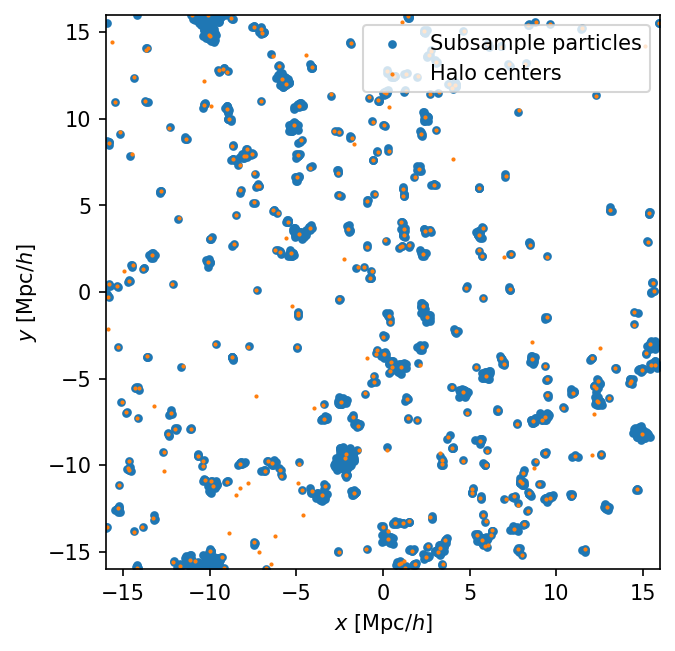

In [5]:
L = cat.header['BoxSize']
fig, ax = plt.subplots(dpi=150)
ax.set_aspect('equal')
ax.set_xlim(-L / 2, L / 2)
ax.set_ylim(-L / 2, L / 2)

ax.scatter(
    cat.subsamples['pos'][:, 0],
    cat.subsamples['pos'][:, 1],
    s=10.0,
    label='Subsample particles',
)
ax.scatter(
    cat.halos['x_L2com'][:, 0],
    cat.halos['x_L2com'][:, 1],
    s=1.0,
    label='Halo centers',
)
ax.set_xlabel('$x$ [Mpc/$h$]')
ax.set_ylabel('$y$ [Mpc/$h$]')

ax.legend(loc='upper right')

The two are in excellent agreement.  We see some halos without subsamples, which is fine, and no subsamples that are missing halos seem to stand out, which is good.

## Finding a halo's subsample particles

The subsample particles come in one big array, ordered by halo. So all we need to know is the starting index and count of subsample particles that belong to a halo.  In the halo catalog, the starting index is called `npstartA` and the count is called `npoutA`.

Let's pick a big halo and use these indices to get its subsample particles:

In [6]:
bighalo = cat.halos[123]
print(bighalo['N'])
print(bighalo['x_L2com'])

287
[-6.0305486 13.056745  -9.907915 ]


In [7]:
bighalo_subsamples = cat.subsamples[
    bighalo['npstartA'] : bighalo['npstartA'] + bighalo['npoutA']
]
bighalo_subsamples['pos'].data  # using .data just so all three columns are printed

array([[-5.99168 , 13.059168, -9.909504],
       [-5.931904, 13.031616, -9.931072],
       [-6.07488 , 13.055808, -9.810816],
       [-6.037824, 13.102976, -9.973056]], dtype=float32)

We see that all 4 subsample particles are within a few 10s of kpc/h of the halo center, as we would expect.  Having only 4 subsample particles is a bit unusual for a halo with 287 particles; we might expect 8.6 on average, but it's a reasonable Poisson fluctuation.

## L0 Halo Particles

One potentially surprising feature of the subsample data model is that there are more subsample particles in the subsample files than the halos think they should have.  For technical reasons, this is hidden from the user through the Python interface, but we can see it if we load the files directly:

In [8]:
def count_raw_subsamples():
    import asdf

    count = 0
    for fn in (catdir / 'halo_rv_A').glob('halo_rv_A_*.asdf'):
        with asdf.open(fn) as af:
            count += len(af['data']['rvint'])
    return count


print(count_raw_subsamples())
print(cat.halos['npoutA'].sum())

2975
2536


So there are about 440 extra, unindexed subsample particles. These are L0 particles: particles that were part of the density-bounded FoF groups that form the first level of segmentation in the CompaSO algorithm. Within each L0 group, multiple halos (L1 groups) can be identified, but not all particles may belong to L1 halos.  These L0-but-not-L1 particles are the unindexed extras.

Most users will never encounter this, unless one is inspecting the raw ASDF files.

## Cleaned Subsample Particles

The halo "cleaning" procedure assigns the mass of one halo to another.  The halo that was "cleaned away" is assigned an `N` of 0.  The subsample particle count is likewise set to 0, and the halo to which it is merged gains those particles in its subsample.  This is all transparent to the user.

However, we can still load the uncleaned halo catalogs and see this reassignment of subsample particles in action for pedagogical purposes.  In this small sim, we only have 1 halo that was cleaned away:

In [9]:
removed_idx = (cat.halos['N'] == 0).argmax()
removed = cat.halos[removed_idx]
removed['N', 'npoutA']

N,npoutA
uint32,uint32
0,0


It we can use the `haloindex` to find the halo it was merged to:

In [10]:
mergedto_idx = (cat.halos['haloindex'] == removed['is_merged_to']).argmax()
mergedto = cat.halos[mergedto_idx]
mergedto['N', 'npoutA']

N,npoutA
uint32,uint32
205,3


And we can look back in the uncleaned catalog to see how many of those particles and subsample particles came from the cleaning:

In [11]:
catunclean = CompaSOHaloCatalog(catdir, subsamples=dict(A=True), cleaned=False)
catunclean.halos[removed_idx]['N', 'npoutA']

N,npoutA
uint32,uint32
60,3


In [12]:
catunclean.halos[mergedto_idx]['N', 'npoutA']

N,npoutA
uint32,uint32
145,0


So in this case, all 3 of the subsample particles came from the merged object.  A bit unusual, but the original object only had a Poisson expectation of `145*0.03 = 4.35` subsample A particles.

## Subsample Particle PIDs

So far, we have only looked at subsample particle positions, but the PID field (really, the aux field) of the particles encodes a lot of information, too.  We can tell abacusutils to load the PIDs with `subsamples=dict(pid=True)`, and then unpack all aux-derived fields with `unpack_bits=True`:

In [13]:
cat = CompaSOHaloCatalog(
    catdir, subsamples=dict(A=True, rv=True, pid=True), unpack_bits=True
)
cat.subsamples

pid,lagr_pos,lagr_idx,tagged,density,pos,vel
int64,float32[3],int16[3],bool,float32,float32[3],float32[3]
141737852987,13.5 .. 0.5,59 .. 33,True,576.0,-14.187456 .. -5.318592,477.53906 .. 108.39844
158917918782,15.0 .. 2.5,62 .. 37,True,484.0,-14.207712 .. -5.357984,228.51562 .. -190.42969
137439019066,13.0 .. 0.0,58 .. 32,True,484.0,-14.151616 .. -5.303104,421.875 .. -117.1875
137443082298,13.0 .. 0.0,58 .. 32,True,484.0,-14.161888 .. -5.317536,342.77344 .. -149.41406
150327918652,14.0 .. 1.5,60 .. 35,True,400.0,-14.237088 .. -5.25504,433.59375 .. -225.58594
141737984060,14.0 .. 0.5,60 .. 33,True,256.0,-14.181344 .. -5.272928,483.39844 .. -210.9375
146032951356,14.0 .. 1.0,60 .. 34,True,324.0,-14.190272 .. -5.247936,489.2578 .. -166.99219
68720066623,15.5 .. -8.0,63 .. 16,True,256.0,-14.398592 .. -4.653216,249.02344 .. 187.5
60129869883,13.5 .. -9.0,59 .. 14,True,484.0,-13.870208 .. -4.550208,404.29688 .. 149.41406


We see a few useful fields. `lagr_pos` is the Lagrangian position of the particle (i.e. the location in the initial particle grid). Therefore the following are the Lagrangian displacements, taking care to wrap any particles that cross the periodic boundary:

In [14]:
lagr_disp = cat.subsamples['pos'] - cat.subsamples['lagr_pos']
lagr_disp[lagr_disp >= L / 2] -= L
lagr_disp[lagr_disp < -L / 2] += L
lagr_disp

4.312544 .. -5.818592
2.7922878 .. -7.857984
4.848385 .. -5.303104
4.838112 .. -5.317536
3.7629128 .. -6.75504
3.818657 .. -5.772928
3.8097267 .. -6.247936
2.101408 .. 3.346784
4.6297913 .. 4.449792
2.8316803 .. 8.541504
2.6740494 .. 8.070976


The `lagr_idx` field is the 3D index of the particle in the initial lattice (`lagr_pos` is computed from this).

The `tagged` field is used for merger tracking (tagged particles were once part of an L2 halo).

The `density` field is a KDE estimate in units of the mean density (radius `cat.header['DensityKernelRad'] = 0.4`, units of initial particle spacing).  We expect particles in clustered regions to have a higher density; we can plot them to see this. We'll make reordered copy of the subsamples to plot the denser particles on top, and apply a log stretch:

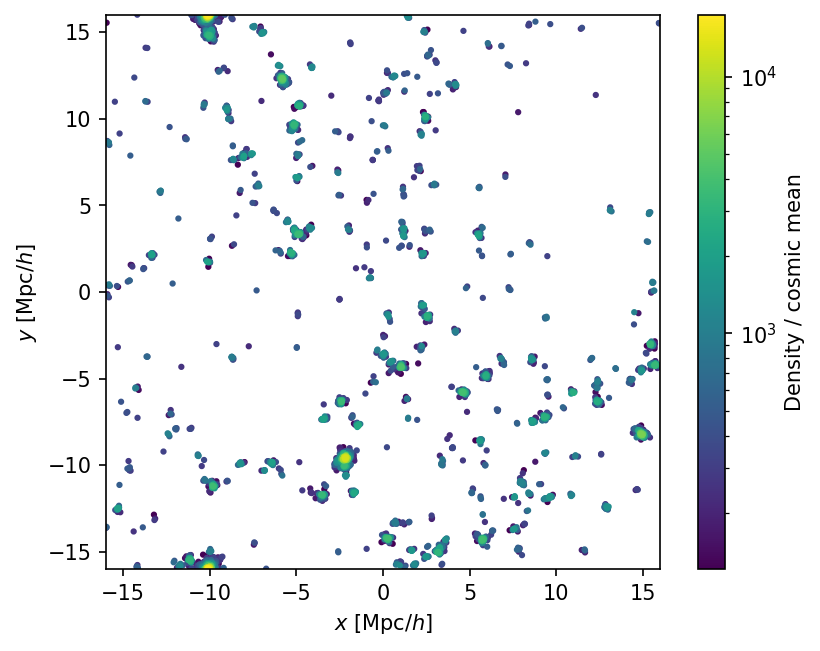

In [15]:
fig, ax = plt.subplots(dpi=150)
ax.set_aspect('equal')
ax.set_xlim(-L / 2, L / 2)
ax.set_ylim(-L / 2, L / 2)
ax.set_xlabel('$x$ [Mpc/$h$]')
ax.set_ylabel('$y$ [Mpc/$h$]')
subsamp_densorder = cat.subsamples[cat.subsamples['density'].argsort()]

sc = ax.scatter(
    subsamp_densorder['pos'][:, 0],
    subsamp_densorder['pos'][:, 1],
    s=4.0,
    c=subsamp_densorder['density'],
    norm=matplotlib.colors.LogNorm(),
)
cbar = fig.colorbar(sc)
cbar.set_label('Density / cosmic mean')

## Efficiently using the indexing data model

### The Numpy Way

Here's a simple question: what is the most distant subsample particle from its halo center?  To compute this efficiently in the Numpy world that we're used to, we would try to solve this problem by broadcasting (or really just by making array shapes match). This is *not* the most efficient way to solve this problem, but we'll demonstrate it first.

We have an array of halo centers of shape `(Nh,3)`, and an array of particle positions `(Np,3)`.  So we need to repeat each halo position as many times as it has subsample particles:

In [16]:
repeats = np.repeat(cat.halos['x_L2com'], cat.halos['npoutA'], axis=0)
dist = cat.subsamples['pos'] - repeats
dist[dist >= L / 2] -= L
dist[dist <= -L / 2] += L
dist

-0.008805275 .. -0.00019741058
-0.029061317 .. -0.039589405
0.02703476 .. 0.015290737
0.016762733 .. 0.0008587837
-0.058437347 .. 0.06335449
-0.0026931763 .. 0.045466423
-0.011621475 .. 0.07045889
-0.014734268 .. 0.027872562
0.040781975 .. 0.049615383
0.1417551 .. 0.078384876
-0.01587677 .. 0.10785675


In [17]:
np.sqrt((dist**2).sum(-1)).max()

0.9396648

So the most distant subsample particle is about 1 Mpc/h away from its halo center, which is very reasonable.

Note that we didn't actually need to use `npstartA` in this approach, because the subsample particles appear in catalog order (the 1 halo removed for cleaning has a special `npstartA` value, but a zero `npoutA` so it doesn't matter):

In [18]:
(cat.halos['npoutA'].cumsum()[:-1] != cat.halos['npstartA'][1:]).sum()

1

### The Numba Way

In the Numpy way, we had to construct a large intermediate array (`repeats`) to do this calculation.  For a small example like this, that was okay, but when the subsample particle data is in the 10s of GB, you won't want to create another array that's *also* 10s of GB, when you could have computed it on the fly.  The numpy approach forces you to construct an intermediate array, which is both slower and less memory efficient.

An alternative is a procedural approach rather than an array-oriented approach.  [Numba](https://numba.pydata.org/) is a good tool for doing this in Python. Here's how we would solve the farthest-particle problem in Numba:

In [19]:
import numba


@numba.njit
def find_farthest(halos, particles, counts):
    k = 0
    maxdist = np.float32(-1.0)
    for i in range(len(halos)):
        cen = halos[i]
        for j in range(counts[i]):
            diff = cen - particles[k + j]
            for m in range(len(diff)):
                if diff[m] > L / 2:
                    diff[m] -= L
                if diff[m] < -L / 2:
                    diff[m] += L
            dist = np.sqrt((diff**2).sum(-1))
            if dist > maxdist:
                maxdist = dist
        k += counts[i]
    return maxdist


find_farthest(cat.halos['x_L2com'], cat.subsamples['pos'], cat.halos['npoutA'])

0.9396647810935974

It gives the same result as Numpy, as we expect.  It's a fair bit lengthier, but the code is all pretty simple.  So the Numpy approach is fine for small sims, but for applications where memory usage or performance are concerned, an approach like this one that avoids creating intermediate arrays like should be preferred.

numba also lends itself well to parallelization; one could use similar code, parallelizing the outer for-loop with `numba.prange()` and using `npstartA` instead of keeping the running counter `k`.